<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_09/2D_vs_3D_CNNs_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_lightning torchio > /dev/null

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training 2D CNN...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 160    | train
1 | conv2 | Conv2d | 4.6 K  | train
2 | fc1   | Linear | 200 K  | train
3 | fc2   | Linear | 1.3 K  | train
-----------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.828     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv3d | 224    | train
1 | conv2 | Conv3d | 3.5 K  | train
2 | fc1   | Linear | 401 K  | train
3 | fc2   | Linear | 1.3 K  | train
-----------------------------------------
406 K     Trainable params
0         Non-trainable params
406 K     Total params
1.626     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode



Training 3D CNN...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



2D CNN Final Validation Accuracy: 98.94%
3D CNN Final Validation Accuracy: 98.95%


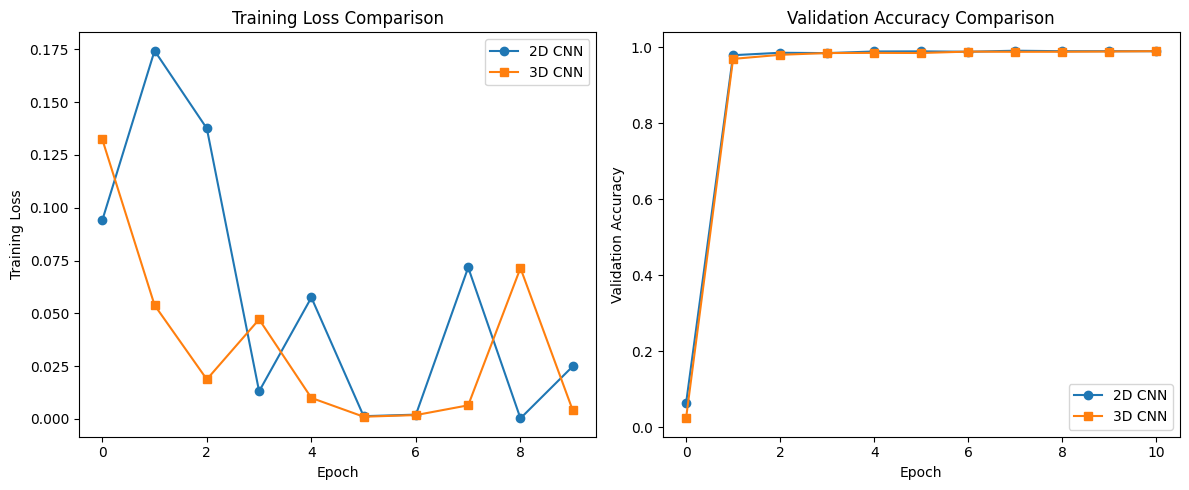

In [3]:
# ======================
# 1. Dataset Definitions
# ======================

class MNIST3D(Dataset):
    def __init__(self, root, train=True, transform=None, depth=16):
        self.mnist = datasets.MNIST(root, train=train, download=True)
        self.transform = transform
        self.depth = depth

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img_np = np.array(img)
        img_3d = np.stack([img_np]*self.depth, axis=0)  # (D, H, W)
        img_tensor = torch.from_numpy(img_3d).float().unsqueeze(0)  # (C, D, H, W)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

# ===================
# 2. Data Modules
# ===================

class MNIST2DDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.mnist_train = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.ToTensor()
        )
        self.mnist_test = datasets.MNIST(
            '../data',
            train=False,
            transform=transforms.ToTensor()
        )

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

class MNIST3DDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.mnist3d_train = MNIST3D('../data', train=True)
        self.mnist3d_test = MNIST3D('../data', train=False)

    def train_dataloader(self):
        return DataLoader(self.mnist3d_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist3d_test, batch_size=self.batch_size)

# ===================
# 3. Model Architectures
# ===================

class CNN2D(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

class CNN3D(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(16*4*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool3d(F.relu(self.conv1(x)), (2, 2, 2))
        x = F.max_pool3d(F.relu(self.conv2(x)), (2, 2, 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

# ===================
# 4. Training & Comparison
# ===================

class MetricTracker(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {'train_loss': [], 'val_acc': []}

    def on_train_epoch_end(self, trainer, pl_module):
        self.metrics['train_loss'].append(trainer.callback_metrics['train_loss'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.metrics['val_acc'].append(trainer.callback_metrics['val_acc'].item())

def train_and_track(model, datamodule):
    tracker = MetricTracker()
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        callbacks=[tracker],
        enable_checkpointing=False,
        logger=False
    )
    trainer.fit(model, datamodule)
    return tracker.metrics

def compare_models():
    # Initialize
    dm_2d = MNIST2DDataModule()
    dm_3d = MNIST3DDataModule()

    # Train and track metrics
    print("Training 2D CNN...")
    metrics_2d = train_and_track(CNN2D(), dm_2d)

    print("\nTraining 3D CNN...")
    metrics_3d = train_and_track(CNN3D(), dm_3d)

    # Print final accuracies
    print(f"\n2D CNN Final Validation Accuracy: {metrics_2d['val_acc'][-1]:.2%}")
    print(f"3D CNN Final Validation Accuracy: {metrics_3d['val_acc'][-1]:.2%}")

    # Plot results
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(metrics_2d['train_loss'], label='2D CNN', marker='o')
    plt.plot(metrics_3d['train_loss'], label='3D CNN', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.title('Training Loss Comparison')

    plt.subplot(122)
    plt.plot(metrics_2d['val_acc'], label='2D CNN', marker='o')
    plt.plot(metrics_3d['val_acc'], label='3D CNN', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Validation Accuracy Comparison')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    compare_models()